In [1]:
%pip install numpy

  Using cached numpy-1.26.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (115 kB)
Using cached numpy-1.26.2-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
Note: you may need to restart the kernel to use updated packages.


# The game settings

In [145]:
import numpy as np
class GameData:
    def __init__(self, means_bound, number_of_arms):
        self.means = np.random.uniform(-means_bound, means_bound, number_of_arms)
        # initialize the predicted means as an array where every valuse is means_bound
        self.predicted_means = np.full(number_of_arms, means_bound)




        self.number_of_observations = np.zeros(number_of_arms)
        self.max_mean = np.max(self.means)
        self.max_mean_index = np.argmax(self.means)
        self.number_of_arms = number_of_arms
        self.means_bound = means_bound
        assert self.means[self.max_mean_index] == self.max_mean

    def reset(self):
        self.predicted_means = np.full(self.number_of_arms, self.means_bound)
        self.number_of_observations = np.zeros(len(self.means))


In [141]:
game_data = GameData(2, 10)

In [142]:
# print the game data in a nice way
print("means: ", game_data.means)
print("predicted_means: ", game_data.predicted_means)
print("number_of_observations: ", game_data.number_of_observations)
print("max_mean: ", game_data.max_mean)
print("max_mean_index: ", game_data.max_mean_index)


means:  [-1.00156764  0.42643924  1.62485426 -0.16141092  0.58069368 -1.32283904
 -1.83588261  0.48414455 -0.65706987 -0.15662154]
predicted_means:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
number_of_observations:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max_mean:  1.6248542586295023
max_mean_index:  2


We need to update the predicted means and number of observation every time we pull an arm

In [113]:
def pull_arm_k(arm, game_data):
    # Pull arm k and update data, return reward
    reward = generate_value(game_data.means[arm])

    # update the number of observations
    game_data.number_of_observations[arm] += 1
    nr_obs = game_data.number_of_observations[arm]

    # update the predicted mean based on the new observation
    game_data.predicted_means[arm] =  game_data.predicted_means[arm] + ((reward - game_data.predicted_means[arm]) / nr_obs)

    return reward


# test the function
print(pull_arm_k(2, game_data))

-1.1533718471564172


In [25]:
%pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 35.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# Computing the KL divergence

Checking the minimum float to avoid dividing by zero

In [61]:
import sys

print("Max float:", sys.float_info.max)
print("Min float:", sys.float_info.min)
print("Machine epsilon (smallest difference between distinct float values):", sys.float_info.epsilon)
print("Max exponent:", sys.float_info.max_exp)
print("Min exponent:", sys.float_info.min_exp)

Max float: 1.7976931348623157e+308
Min float: 2.2250738585072014e-308
Machine epsilon (smallest difference between distinct float values): 2.220446049250313e-16
Max exponent: 1024
Min exponent: -1021


In [81]:
from scipy.stats import norm

# function to compute Kullback-Leibler divergence
def kl_divergence(p_mean, q_mean, nr_of_samples, verbose=False):
    # assert that the difference between the means is smaller than 20
    assert np.abs(p_mean - q_mean) < 20, "The difference between the means is too large: " + str(np.abs(p_mean - q_mean))


    # draw samples from the p distribution
    p_samples = np.random.normal(p_mean, 1, nr_of_samples)

    # Calculate the PDF values for each sample
    p_pdf_values = norm.pdf(p_samples, p_mean, 1)

    # Calculate the PDF values of q for each sample
    q_pdf_values = norm.pdf(p_samples, q_mean, 1)

    # count the number of zeros in the q_pdf_values
    nr_of_zeros = np.count_nonzero(q_pdf_values == 0)
    if verbose:
        print('Number of zeros in q_pdf_values: ', nr_of_zeros)
    # count the number of values smaller than 1e-100
    nr_of_small_values = np.count_nonzero(q_pdf_values < 1e-100)
    if verbose:
        print('Number of values smaller than 1e-100 in q_pdf_values: ', nr_of_small_values)

    #replace small values with 1e-100 because dividing by zero would result in infinity
    q_pdf_values[q_pdf_values < 1e-100] = 1e-100

    # Calculate the ratio of the two PDFs
    pdf_ratio = p_pdf_values / q_pdf_values
    # Calculate the log of the ratio
    log_pdf_ratio = np.log(pdf_ratio)

    # Calculate the mean of the log of the ratio
    mean_log_pdf_ratio = np.mean(log_pdf_ratio)
    
    # assert that the mean is a single number
    assert np.isscalar(mean_log_pdf_ratio)

    return mean_log_pdf_ratio

In [72]:
#test the function
print(kl_divergence(20, 0, 1000))


Number of zeros in q_pdf_values:  0
Number of values smaller than 1e-100 in q_pdf_values:  64
199.0001117612442


# Computing Lai-Robbins bound

In [97]:
# A constant for the Lai-Robbins lower bound function
def compute_A(game_data, nr_of_samples = 10000, verbose=False):
    # get an arraw with all the means except the max mean
    means = game_data.means
    max_mean_index = game_data.max_mean_index
    max_mean = game_data.max_mean

    sub_optimal_means = np.concatenate([means[:max_mean_index], means[max_mean_index+1:]])
    # assearch that the max mean is not contained in the sub_optimal_means
    assert max_mean not in sub_optimal_means

    
    #get the regret for each suboptimal mean
    regrets = max_mean - sub_optimal_means
    if verbose:
        print("regrets: ", regrets)
 

    # compute the kl divergence for each suboptimal mean
    kl_divergences = np.array([kl_divergence(mean, max_mean, nr_of_samples) for mean in sub_optimal_means])

    if verbose:
        print("kl_divergences: ", kl_divergences)

    # compute regrets divided by kl divergences
    regrets_divided_by_kl_divergences = regrets / kl_divergences
    if verbose:
        print("regrets_divided_by_kl_divergences: ", regrets_divided_by_kl_divergences)

    #sum all the regrets divided by kl divergences
    return np.sum(regrets_divided_by_kl_divergences)



    

In [100]:
# test the function
print(compute_A(game_data, verbose=True))

regrets:  [2.88287927 2.39718478 1.2533006  3.43377969 3.79553282 2.88730872
 2.03827181 1.52098288 3.83852142]
kl_divergences:  [4.13862355 2.88836287 0.76158944 5.91502842 7.20569423 4.1163638
 2.08304048 1.15005277 7.34332573]
regrets_divided_by_kl_divergences:  [0.69657924 0.82994585 1.64563809 0.58051787 0.52674076 0.70142214
 0.97850802 1.32253313 0.52272248]
7.804607578461493


In [122]:
def Lai_Robbins_lower_bound(A, t):
    return 2 * A * np.log(t)

In [86]:
%pip install matplotlib

  Using cached matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached Pillow-10.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.5 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl (7.5 MB)
Using cached contourpy-1.2.0-cp311-cp311-macosx_11_0_arm64.whl (243 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.6 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl (66 kB)
Using cached Pillow-10.1.0-cp311-cp311-macosx_11_0_arm64.whl (3.3 MB)
Using cached pyparsin

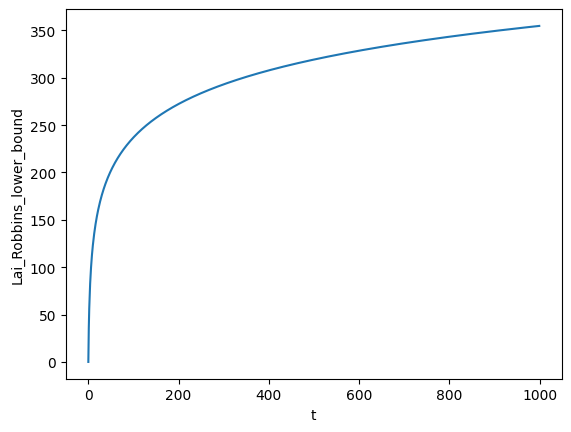

In [124]:
#plot the Lai_Robbins_upper_bound for 1000 steps
import matplotlib.pyplot as plt
%matplotlib inline

# compute the A constant
A = compute_A(game_data)

# compute the Lai_Robbins_upper_bound for 1000 steps
bound = [Lai_Robbins_lower_bound(A, t) for t in range(1, 1001)]

# plot the Lai_Robbins_upper_bound
plt.plot(bound)
plt.xlabel('t')
plt.ylabel('Lai_Robbins_lower_bound')
plt.show()



# Running the algorithms

## Epsilon greedy

In [128]:
def epsilon_greedy(epsilon, game_data, number_of_steps):
    # reset the game data
    game_data.reset()

    # Compute the A constant
    A = compute_A(game_data)

    max_mean = game_data.max_mean
    max_mean_index = game_data.max_mean_index
    number_of_arms = game_data.number_of_arms

    # Variables tracked over time to plot them afterwards
    cumulative_regret = 0
    cumulative_regret_over_time = []
    lower_bound = []

    arm_chosen = []
    best_predicted_means = []
    best_predicted_arms = []

    for t in range(1, number_of_steps + 1):
        # Generate a random number between 0 and 1
        random_number = np.random.uniform(0, 1)

        # Get prediction
        predicted_means = game_data.predicted_means
        best_predicted_arm = np.argmax(predicted_means)
        best_predicted_mean = predicted_means[best_predicted_arm]

        best_predicted_arms.append(best_predicted_arm)
        best_predicted_means.append(best_predicted_mean)
        
        lower_bound.append(Lai_Robbins_lower_bound(A, t))
        
        # If the random number is less than epsilon, pull a random arm
        if random_number < epsilon:
            sub_optimal_arm_indices = [i for i in range(number_of_arms) if i != best_predicted_arm]
            # Choose a random suboptimal arm
            arm = np.random.choice(sub_optimal_arm_indices)
            # Pull the arm and updates the predicted means
            reward = pull_arm_k(arm, game_data)
            arm_chosen.append(arm)

            # Update the cumulative regret
            cumulative_regret += max_mean - game_data.means[arm]
            cumulative_regret_over_time.append(cumulative_regret)
            
        # Otherwise, pull the arm with the highest mean
        else:
            # Pull the optimal arm based on the predicted means
            reward = pull_arm_k(best_predicted_arm, game_data)
            arm_chosen.append(best_predicted_arm)
            # Update the cumulative regret
            cumulative_regret += max_mean - game_data.means[best_predicted_arm]
            cumulative_regret_over_time.append(cumulative_regret)
            
    return cumulative_regret_over_time, lower_bound, best_predicted_means, best_predicted_arms, arm_chosen, game_data

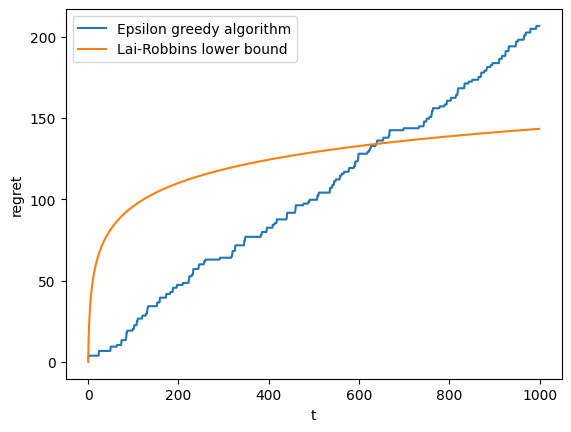

In [146]:
# test the function and plot the cumulative regret over time with the Lai_Robbins_lower_bound

# set the number of steps
number_of_steps = 1000

# set the epsilon
epsilon = 0.1

# run the epsilon_greedy algorithm
cumulative_regret_over_time, lower_bound,_,_,_, game_data = epsilon_greedy(epsilon, game_data, number_of_steps)

# plot the cumulative regret over time
plt.plot(cumulative_regret_over_time)
plt.plot(lower_bound)
plt.xlabel('t')
plt.ylabel('regret')
plt.legend(['Epsilon greedy algorithm', 'Lai-Robbins lower bound'])
plt.show()

### Plotting regret for different epsilons

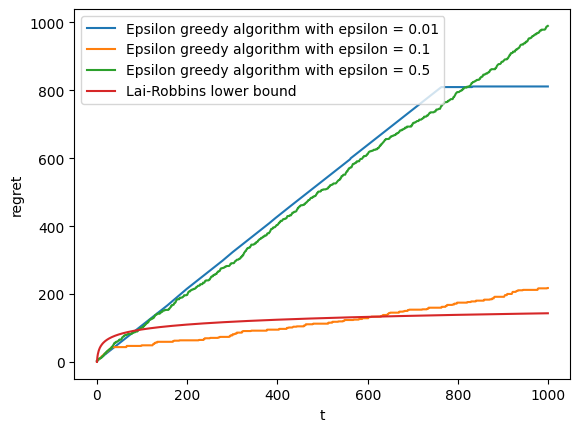

In [153]:
# do the plot for different values of epsilon on the same graph
number_of_steps = 1000
epsilons = [0.01, 0.1, 0.5]

for epsilon in epsilons:
    cumulative_regret_over_time, lower_bound,_,_,arm_chosen, game_data = epsilon_greedy(epsilon, game_data, number_of_steps)
    plt.plot(cumulative_regret_over_time)
    
plt.plot(lower_bound)
plt.xlabel('t')
plt.ylabel('regret')
plt.legend(['Epsilon greedy algorithm with epsilon = ' + str(epsilon) for epsilon in epsilons] + ['Lai-Robbins lower bound'])
plt.show()

### Plotting accuracy

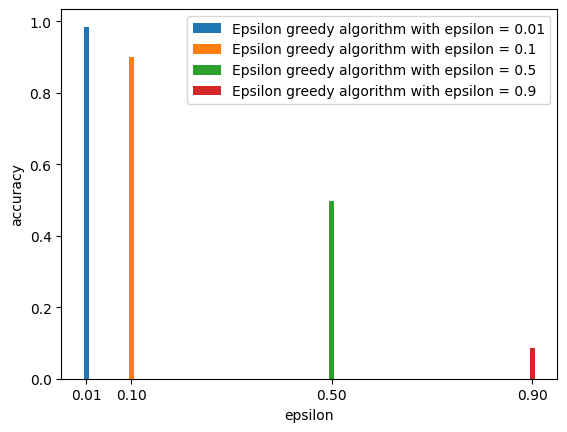

In [171]:
#plot the accuracy of the algorithm in a bar plot
number_of_steps = 1000
epsilons = [0.01, 0.1, 0.5, 0.9]
best_arm_index = game_data.max_mean_index

#set the bar plot

for epsilon in epsilons:
    _,_,best_predicted_means,_,arm_chosen, game_data = epsilon_greedy(epsilon, game_data, number_of_steps)
    accuracy = np.count_nonzero(arm_chosen == best_arm_index) / number_of_steps
    plt.bar(epsilon, accuracy, width=0.01)

plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.xticks(epsilons)
plt.legend(['Epsilon greedy algorithm with epsilon = ' + str(epsilon) for epsilon in epsilons])
plt.show()

    

    


# UCB algorithm

In [188]:
def UCB(c, game_data, number_of_steps):
    # reset the game data
    game_data.reset()

    # Compute the A constant
    A = compute_A(game_data)

    max_mean = game_data.max_mean
    max_mean_index = game_data.max_mean_index
    number_of_arms = game_data.number_of_arms

    # Variables tracked over time to plot them afterwards
    cumulative_regret = 0
    cumulative_regret_over_time = []
    lower_bound = []

    arm_chosen = []
    best_UCBS = []

    for t in range(1, number_of_steps + 1):

        # Get prediction
        predicted_means = game_data.predicted_means


        # Compute the upper confidence bound for each arm
        UCBs = predicted_means + c * np.sqrt(np.log(t) / [1 if nr_obs==0 else nr_obs for nr_obs in game_data.number_of_observations]) # avoid division by zero


        best_predicted_arm = np.argmax(UCBs)
        best_UCB = UCBs[best_predicted_arm]

        best_UCBS.append(best_UCB)
        
        lower_bound.append(Lai_Robbins_lower_bound(A, t))

       
        # Pull the optimal arm based on the predicted means
        reward = pull_arm_k(best_predicted_arm, game_data)
        arm_chosen.append(best_predicted_arm)
        # Update the cumulative regret
        cumulative_regret += max_mean - game_data.means[best_predicted_arm]
        cumulative_regret_over_time.append(cumulative_regret)
            
    return cumulative_regret_over_time, lower_bound, best_UCBS, arm_chosen, game_data

### plotting regret

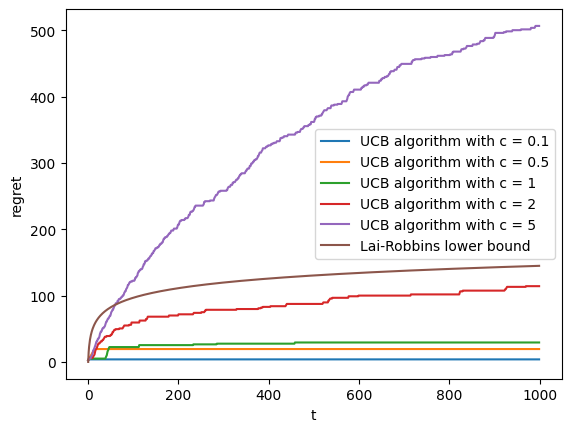

In [189]:
# plot the cumulative regret over time with the Lai_Robbins_lower_bound for different values of c

# set the number of steps
number_of_steps = 1000

# set the c values
c_values = [0.1, 0.5, 1, 2, 5]


# run the UCB algorithm for each c value
for c in c_values:
    cumulative_regret_over_time, lower_bound,_,_, game_data = UCB(c, game_data, 
    number_of_steps)
    plt.plot(cumulative_regret_over_time)

plt.plot(lower_bound)
plt.xlabel('t')
plt.ylabel('regret')
plt.legend(['UCB algorithm with c = ' + str(c) for c in c_values] + ['Lai-Robbins lower bound'])
plt.show()

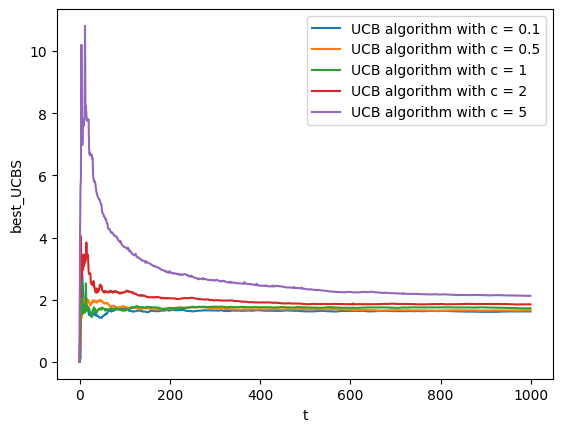

In [190]:
# plot the mean of the chosen arms over time for different values of c

# set the number of steps
number_of_steps = 1000

# set the c values
c_values = [0.1, 0.5, 1, 2, 5]

# run the UCB algorithm for each c value
for c in c_values:
    _,_, best_UCBS, arm_chosen, game_data = UCB(c, game_data, number_of_steps)
    plt.plot(best_UCBS)


plt.xlabel('t')
plt.ylabel('best_UCBS')
plt.legend(['UCB algorithm with c = ' + str(c) for c in c_values])
plt.show()


    

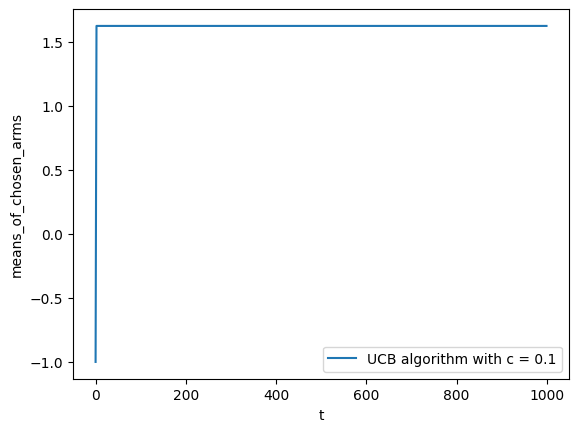

In [191]:
# plot the actual means of the chosen arms over time for different values of c

# set the number of steps
number_of_steps = 1000

# set the c values
c_values = [0.1]

# run the UCB algorithm for each c value
for c in c_values:
    _,_,_, arm_chosen, game_data = UCB(c, game_data, number_of_steps)
    means_of_chosen_arms = [game_data.means[arm] for arm in arm_chosen]
    plt.plot(means_of_chosen_arms)

plt.xlabel('t')
plt.ylabel('means_of_chosen_arms')
plt.legend(['UCB algorithm with c = ' + str(c) for c in c_values])
plt.show()


/var/folders/d8/_xc_qyn9121fv2fflg18bqxc0000gn/T/ipykernel_6335/3667575758.py:27: RuntimeWarning: invalid value encountered in divide
  UCBs = predicted_means + c * np.sqrt(np.log(t) / game_data.number_of_observations)
/var/folders/d8/_xc_qyn9121fv2fflg18bqxc0000gn/T/ipykernel_6335/3667575758.py:27: RuntimeWarning: divide by zero encountered in divide
  UCBs = predicted_means + c * np.sqrt(np.log(t) / game_data.number_of_observations)


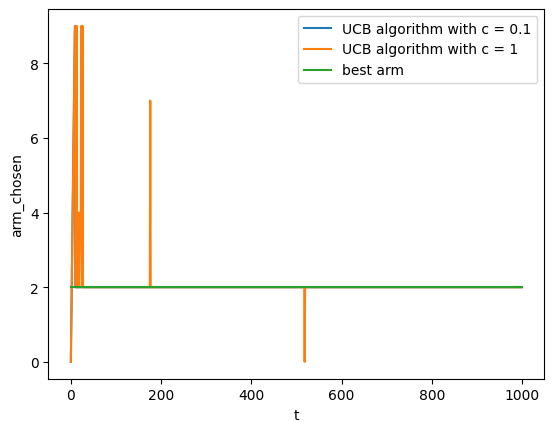

In [162]:
#plot just the chosen arms for different values of c

# set the number of steps
number_of_steps = 1000

# set the c values
c_values = [0.1, 1]


#get the index of the best arm


# run the UCB algorithm for each c value
for c in c_values:
    _,_,_, arm_chosen, game_data = UCB(c, game_data, number_of_steps)
    plt.plot(arm_chosen)

best_arm_index = game_data.max_mean_index
# plot the best arm
plt.plot([best_arm_index]*number_of_steps)
plt.xlabel('t')
plt.ylabel('arm_chosen')
plt.legend(['UCB algorithm with c = ' + str(c) for c in c_values]+['best arm'])
plt.show()



### plotting the accuracy

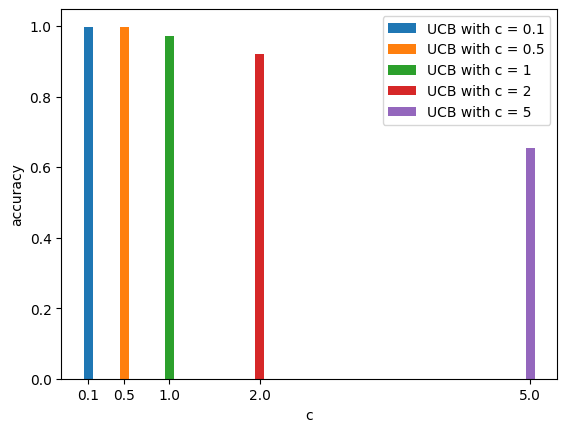

In [192]:
# compute the accuracy of the UCB algorithm for different values of c and make a bar plot
number_of_steps = 1000
c_values = [0.1, 0.5, 1, 2, 5]
best_arm_index = game_data.max_mean_index
# run the UCB algorithm for each c value
for c in c_values:
    _,_,_, arm_chosen, game_data = UCB(c, game_data, number_of_steps)
    accuracy = np.count_nonzero(arm_chosen == best_arm_index) / number_of_steps
    plt.bar(c, accuracy, width=0.1)

plt.xlabel('c')
#set the xticks to the c values

plt.xticks(c_values)
plt.ylabel('accuracy')
plt.legend(['UCB with c = ' + str(c) for c in c_values])
plt.show()

    